This notebook fits $k_{agg}$ parameters to species in the BCI plot at multiple scales, and calculates the slope $z$ of the log(Area) vs log(k) relationship to investigate power law scaling behavior.

The `bci5.txt` file contains the raw census data from the BCI plot. Unfortunately these data are not included in this repo due to limitations on redistribution of data. At the time of writing, this data can be requested by filling out the [data request form](http://ctfs.si.edu/webatlas/datasets/bci/) at the CTFS website. Once this data is retrieved as a tab-separated file and placed in the same directory as this notebook, the analyses below can be run.

In [1]:
import pandas as pd
import numpy as np
from scipy.special import gammaln

In [2]:
# Read the BCI 2005 data as a data frame
bci_raw = pd.read_csv("bci5.txt", "\t")

In [3]:
# Remove dead stems
bci_alive = bci_raw[bci_raw["status"]=="A"]
bci_alive.head()

,tag,sp,gx,gy,dbh,pom,date,codes,status
0,105951,ACACME,610.0,104.7,119.0,1,9290.0,M,A
1,132160,ACACME,534.8,241.3,116.0,1,9288.0,*,A
4,191542,ACACME,282.7,177.5,75.0,1,9191.0,*,A
5,269064,ACACME,84.2,74.8,21.0,1,9149.0,*,A
6,272540,ACACME,149.9,389.8,20.0,1,9199.0,*,A


In [4]:
# Get array of species names
spp_names = np.unique(bci_raw['sp'])

# Define list to hold names of species for which calculations are done
spp_names_used = []

In [5]:
# Declare empty data frame to hold k for each species at each scale
# Largest cell is 250x250, which gives 8 replicates in the full plot, which is 1000x500
# Smallest cell is 1/7 of this length on a side, giving 392 replicates
k_table = pd.DataFrame({"side_length": 250/np.array([1,2,3,4,5,6,7]),
                        "xdivs": 4*np.array([1,2,3,4,5,6,7]),
                        "ydivs": 2*np.array([1,2,3,4,5,6,7])})

In [6]:
# Define a function to calculate neg log L for NBD
def negLLnbd(x, mu, k_agg):
    coeff = gammaln(k_agg+x) - gammaln(x+1) - gammaln(k_agg)
    return -np.sum(coeff + k_agg*np.log(k_agg/(k_agg+mu)) + x*np.log(mu/(k_agg+mu)))

In [15]:
# Loop through all species and calculate k for each species, at each scale
for spp_name in spp_names:
    
    # Filter bci_alive table to just this spp
    spp_table = bci_alive[bci_alive["sp"] == spp_name]
    
    # If fewer than 100 individuals of this spp, skip (ensures mean abundance per cell at smallest scale > ~1)
    if spp_table.shape[0] < 100:
        continue
    else:
        spp_names_used.append(spp_name)

    # Set up empty list to hold k values for this spp at all cell sizes
    spp_ks = []
        
    # Loop through side lengths
    for xdiv, ydiv in zip(k_table["xdivs"], k_table["ydivs"]):
        
        # Calculate 2D histogram giving counts in cells of this side_length
        hist = np.histogram2d(spp_table["gx"], spp_table["gy"], [xdiv, ydiv], [[0,1000], [0,500]])
        
        # Optimization methods for finding MLE k are difficult and prone to non-convergence
        # We brute force it here - calculate neg log L for k from 0.1 to 200 in steps of 0.1 and grab the min
        k_array = np.arange(0.1, 200.1, 0.1)
        L_array = np.full(2000, np.nan)

        mu = np.sum(hist[0]) / (xdiv*ydiv)  # Mean individs per cell

        for i, k_agg in enumerate(k_array):
            L_array[i] = negLLnbd(hist[0].flatten(), mu, k_agg)

        k_mle = k_array[np.argmin(L_array)]
            
        # Store the mle of k in list of ks for this spp
        spp_ks.append(k_mle)
        
    # Store k values for this spp in large k_table
    k_table[spp_name] = spp_ks


In [8]:
k_table

,side_length,xdivs,ydivs,ACALDI,ADE1TR,ALCHCO,ALIBED,ALLOPS,ALSEBL,ANAXPA,...,TRI2PA,TRI2TU,TRIPCU,TROPRA,UNONPI,VIROSE,VIROSU,XYL1MA,ZANTBE,ZANTP1
0,250.000000,4,2,9.2,4.0,14.0,26.1,36.9,17.2,0.1,...,4.0,4.3,1.8,5.6,4.9,10.4,6.0,0.8,3.9,7.0
1,125.000000,8,4,2.1,0.8,3.3,3.2,5.8,7.6,0.1,...,2.5,3.4,1.0,3.7,1.1,4.6,2.4,0.5,1.8,2.1
2,83.333333,12,6,1.8,0.4,1.8,2.1,2.9,5.1,0.1,...,2.1,2.9,1.0,2.9,1.0,3.3,1.6,0.5,1.2,1.3
3,62.500000,16,8,1.0,0.3,1.3,2.0,1.6,4.0,0.1,...,1.7,2.7,0.8,2.3,0.8,2.7,1.4,0.4,0.9,1.0
4,50.000000,20,10,0.8,0.2,0.8,1.6,1.0,3.5,0.1,...,1.8,2.5,0.6,2.4,0.8,2.4,1.0,0.4,0.7,0.6
5,41.666667,24,12,0.7,0.2,0.7,1.6,0.6,2.9,0.1,...,1.4,2.2,0.6,1.4,0.7,2.4,1.1,0.3,0.5,0.5
6,35.714286,28,14,0.4,0.2,0.5,1.3,0.6,2.6,0.1,...,1.4,2.0,0.6,1.8,0.8,2.5,0.8,0.3,0.4,0.4


In [9]:
# Fit a linear regression for log(A) ~ z log(k) + c
# Model prediction and Taylor's law data suggest z ~ 0.5

# Calcuate log(A) array
logA = np.log(k_table["side_length"]**2)

# Set up dataframe to hold spp_name, z, and c for that spp
z_table = pd.DataFrame(columns=["spp_name", "z", "c"])

# Loop through all spp
for spp_name in spp_names_used:

    # Calculate log(k) array
    logk = np.log(k_table[spp_name])

    # Calculate best fit line
    regress = np.polyfit(logA, logk, 1)  # Two values returned, z then c (note unintuitive order)
    
    # Store in z_table
    z_table = z_table.append({"spp_name": spp_name, "z": regress[0], "c": regress[1]}, ignore_index=True)

In [10]:
# Save the z_table as a csv to be read for plotting
z_table.to_csv("bci_zs.csv")

In [11]:
print(np.mean(z_table["z"]))
print(np.median(z_table["z"]))

0.417526128499
0.37917903223


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1151419b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115178940>]], dtype=object)

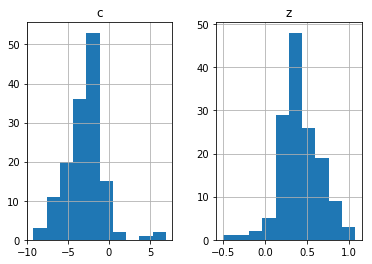

In [13]:
%matplotlib inline
z_table.hist()